In [1]:
import csv
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import random_split

from network import ConvNN
from custom_dataset import CustomDataset

# Running on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.25),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]
)

def label_transform(label):
    if label == 'open': 
        return 0
    elif label == 'sunglasses':
        return 1
    else:
        raise ValueError('Invalid label')

# Create Datasets for training and testing
train_dataset = CustomDataset(
    data_dir = './resource/train',
    label_dir = './resource/train_tags.csv',
    data_mode = "train",
    transform = transform,
    label_transform = label_transform
)

test_dataset = CustomDataset(
    data_dir = './resource/test',
    label_dir = None,
    data_mode = "test",
    transform = transform
)

In [3]:
total_train_samples = len(train_dataset)
val_size = int(total_train_samples * 0.2)
train_size = total_train_samples - val_size

# Split the data set
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader for training and validation
train_loader = DataLoader(dataset=train_subset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset=val_subset, batch_size=15, shuffle=False)

In [9]:
cnn = ConvNN().to(device)

# Define loss function and optimizer
epoch_iter = 40
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.002, weight_decay=2e-6)
print(f'Epoch\ttrain_Loss\tval_Loss\ttrain_Acc\tval_acc')

avg_train_loss_list = []
train_accuracy_list = []
avg_val_loss_list = []
val_accuracy_list = []

for epoch in range(epoch_iter):
    # Training model
    cnn.train()
    train_running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        # Get input data
        inputs, labels = data
        # Gradient zero
        optimizer.zero_grad()
        # Forward + Backward + Optimize
        outputs = cnn(inputs)
        train_loss = criterion(outputs, labels)
        train_loss.backward()
        optimizer.step()
        train_running_loss += train_loss.item()
        # Calculate accurate count and total count
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    # Calculate the loss and accuracy on train_set
    avg_train_loss = train_running_loss / train_size * train_loader.batch_size
    avg_train_loss_list.append(avg_train_loss)
    train_accuracy = correct / total
    train_accuracy_list.append(train_accuracy)

    # Verify on the validation set
    cnn.eval()
    val_running_loss = 0
    correct = 0
    total = 0
    # Disable the Gradient
    with torch.no_grad():
        for data in val_loader:
            # Get input data
            images, labels = data
            # Forward
            outputs = cnn(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            # Calculate accurate count and total count
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()      
    # Calculate the loss and accuracy on val_set
    avg_val_loss = val_running_loss / val_size * val_loader.batch_size
    avg_val_loss_list.append(avg_val_loss)
    val_accuracy = correct / total
    val_accuracy_list.append(val_accuracy)

    # Print statistics
    print(f'{epoch + 1}\t{avg_train_loss:.3f}\t\t{avg_val_loss:.3f}\t\t{train_accuracy:.3f}\t\t{val_accuracy:.3f}')


Epoch	train_Loss	val_Loss	train_Acc	val_acc
1	0.700		0.687		0.508		0.733
2	0.645		0.579		0.670		0.693
3	0.536		0.531		0.772		0.773
4	0.517		0.523		0.799		0.787
5	0.505		0.519		0.815		0.800
6	0.483		0.514		0.825		0.773
7	0.448		0.436		0.865		0.893
8	0.415		0.451		0.911		0.840
9	0.408		0.451		0.901		0.827
10	0.393		0.424		0.921		0.893
11	0.389		0.402		0.914		0.893
12	0.368		0.369		0.947		0.947
13	0.346		0.386		0.967		0.920
14	0.360		0.384		0.950		0.920
15	0.356		0.376		0.957		0.933
16	0.364		0.385		0.944		0.933
17	0.352		0.365		0.970		0.933
18	0.359		0.421		0.957		0.867
19	0.365		0.372		0.947		0.947
20	0.363		0.386		0.950		0.907
21	0.362		0.367		0.937		0.947
22	0.350		0.350		0.970		0.960
23	0.348		0.345		0.974		0.973
24	0.338		0.349		0.980		0.960
25	0.334		0.342		0.980		0.973
26	0.339		0.342		0.977		0.973
27	0.346		0.366		0.970		0.933
28	0.338		0.342		0.970		0.973
29	0.343		0.406		0.974		0.907
30	0.332		0.359		0.983		0.960
31	0.344		0.350		0.967		0.960
32	0.353		0.357		0.957		0.960
33	0.

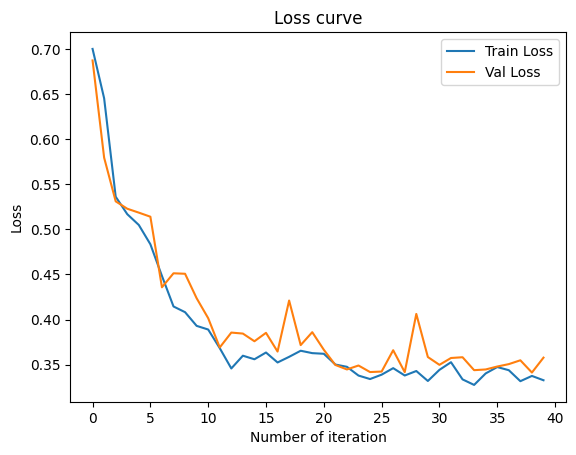

In [10]:
# Show the Loss curve
plt.plot(range(epoch_iter), avg_train_loss_list, label = "Train Loss")
plt.plot(range(epoch_iter), avg_val_loss_list, label = "Val Loss")

plt.legend()
plt.title("Loss curve")
plt.xlabel("Number of iteration")
plt.ylabel("Loss")

plt.show()

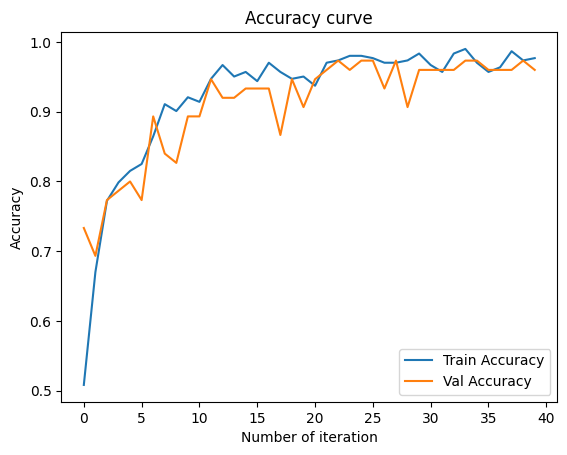

In [11]:
# Show the Accuracy curve
plt.plot(range(epoch_iter), train_accuracy_list, label = "Train Accuracy")
plt.plot(range(epoch_iter), val_accuracy_list, label = "Val Accuracy")

plt.legend()
plt.title("Accuracy curve")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")

plt.show()

In [12]:
# save the model
torch.save(cnn.state_dict(), './model/cnn_state_dict.pth')

In [13]:
# Set to evaluation mode
cnn.eval()  
test_loader = DataLoader(dataset=test_dataset, shuffle=False)

# Open a new CSV file for writing
with open('./result/predictions.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id', 'result'])

    with torch.no_grad():  # Disable the Gradient
        for inputs, labels in test_loader:
            outputs = cnn(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the most probable prediction result

            # Iterate over each sample in the batch
            for label, prediction in zip(labels, predicted):
                writer.writerow([label, prediction.item()])
